# 8.1 FGSM 공격

정상 이미지와 노이즈를 더해 머신러닝 모델을 헷갈리게 하는 이미지가
바로 적대적 예제(Adversarial Example) 입니다.
이 프로젝트에선 Fast Gradient Sign Method, 즉 줄여서 FGSM이라는 방식으로
적대적 예제를 생성해 미리 학습이 완료된 딥러닝 모델을 공격해보도록 하겠습니다.

FGSM 학습이 필요 없지만 공격 목표를 정할 수 없는 Non-Targeted 방식의 공격입니다.
또, 공격하고자 하는 모델의 정보가 필요한 White Box 방식입니다.

공격이 어떻게 진행되는지 단계별로 설명하도록 하겠습니다.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1)

## 학습된 모델 불러오기

`torchvison`은 `AlexNet`, `VGG`, `ResNet`, `SqueezeNet`, `DenseNet`, `Inception`등 여러가지 학습된 모델들을 제공합니다.
대부분 ImageNet이라는 데이터셋으로 학습된 모델이며,
컬러 이미지를 다루는 컴퓨터 비전 분야의 대표적인 데이터셋입니다.

간단하게 사용하고자 하는 모델을 고르고,
함수 내에 `pretrained=True`를 명시하면
학습된 모델을 가져옵니다.
이미 학습된 모델이므로 재학습을 시킬 필요 없이 우리가 원하는
이미지를 분류하게 할 수 있습니다.

본 예제에선 `ResNet101`이라는 모델을 사용하고 있습니다.
너무 복잡하지도 않고, 너무 간단하지도 않은 적당한 모델이라 생각하여 채택하게 되었습니다.
ImageNet 테스트 데이터셋을 돌려보았을때
Top-1 error 성능은 22.63,
Top-5 error는 6.44로 성능도 좋게 나오는 편입니다.
모델을 바꾸고 싶다면 이름만 바꾸면 됩니다.
성능을 더 끌어올리고 싶다면 `DenseNet`이나 `Inception v3`같은 모델을 사용하고,
노트북 같은 컴퓨터를 사용해야된다면 `SqueezeNet`같이 가벼운 모델을 사용하면 됩니다.


In [3]:
model = models.resnet50(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## 데이터셋 불러오기

방금 불러온 모델을 그대로 사용할 수 있지만,
실제 예측값을 보면 0부터 1000까지의 숫자를 내뱉을 뿐입니다.
이건 ImageNet 데이터셋의 클래스들의 지정 숫자(인덱스) 입니다.
사람이 각 클래스 숫자가 무엇을 의미하는지 알아보기 위해선
숫자와 클래스 이름을 이어주는 작업이 필요합니다.

미리 준비해둔 `imagenet_classes.json`이라는 파일에 각 숫자가 어떤 클래스 제목을 의미하는지에 대한 정보가 담겨있습니다.
`json`파일을 파이썬 사용자들에게 좀더 친숙한
딕셔너리 자료형으로 만들어 언제든 사용할 수 있도록
인덱스에서 클래스로 매핑해주는 `idx2class`와
반대로 클래스 이름을 숫자로 변환해주는`class2idx`을 만들어보겠습니다.

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]
class2idx = {v:i for i,v in enumerate(idx2class)}

## 공격용 이미지 불러오기

모델이 준비되었으니 공격하고자 하는 이미지를 불러오겠습니다.
실제 공격에 사용될 데이터는 학습용 데이터에 존재하지 않을 것이므로
우리도 데이터셋에 존재하지 않는 이미지를 새로 준비해야 합니다.

인터넷에 존재하는 이미지는 다양한 사이즈가 있으므로
새로운 입력은 `torchvision`의 `transforms`를 이용하여
이미지넷과 같은 사이즈인 224 x 224로 바꿔주도록 하겠습니다.
그리고 파이토치 텐서로 변환하고, 노말라이즈를 하는 기능을 추가하여
`img_transforms`를 통과시키면 어떤 이미지던 입력으로 사용할 수 있도록 합니다.

In [5]:
img_transforms = transforms.Compose(
    [transforms.Resize((224, 224), Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

이미지넷 데이터셋에는 치와와(Chihuahua)라는 클래스가 존재합니다.
그래서 약간 부담스럽지만 귀여운 치와와 사진을 준비해보았습니다.

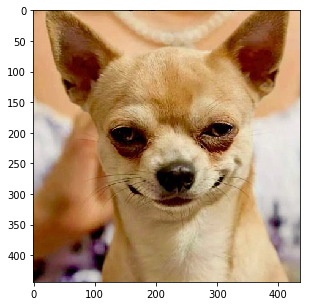

In [6]:
img = Image.open('imagenet_samples/chihuahua.jpg')
img_tensor = img_transforms(img)

plt.figure(figsize=(10,5))
plt.imshow(np.asarray(img))

## 공격 전 성능 확인하기

공격을 하기 전에 우리가 준비한 학습용 데이터에 없는
이미지를 얼마나 잘 분류하나 확인하겠습니다.
분류하는 것은 매우 간단한데,
아까 준비한 모델에 이미지를 통과시키기만 하면 됩니다.
모델에서 나온 값에 `Softmax`를 씌우면
각각의 레이블에 대한 확률 예측값으로 환산됩니다.

```python
out = model(img_tensor.unsqueeze(0))
probs = softmax(out)
```

그리고 `argmax`를 이용하여 가장 큰 확률을 갖고 있는 인덱스,
즉, 모델이 가장 확신하는 예측값을 가져올 수 있습니다.

우리가 준비한 ResNet101 모델은 정확하게 치와와라고 분류하는 것을 볼 수 있습니다.
신뢰도도 99.87%로 매우 치와와라고 확신하고 있네요.

```
151:Chihuahua:18.289345:0.9987244
```

In [7]:
softmax = torch.nn.Softmax()

In [8]:
img_tensor.requires_grad_(True)
out = model(img_tensor.unsqueeze(0))
probs = softmax(out)
cls_idx = np.argmax(out.data.numpy())
print(str(cls_idx) + ":" + idx2class[cls_idx] + ":" + str(out.data.numpy()[0][cls_idx]) + ":" + str(probs.data.numpy()[0][cls_idx]))

151:Chihuahua:17.840199:0.9977261


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


### 이미지 변환하기


입력에 사용되는 이미지는 노말라이즈되어 있으므로,
다시 사람의 눈에 보이게 하기 위해서는 반대로 변환시켜주는 작업이 필요합니다.
`norm`함수는 Normalize를, `unnorm`함수는 다시 사람의 눈에 보이게
복원시켜주는 역활을 합니다.

In [9]:
def norm(x):
    return 2.*(x/255.-0.5)

def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    un_x[un_x > 255] = 255
    un_x[un_x < 0] = 0
    un_x = un_x.astype(np.uint8)
    return un_x

## 적대적 예제 시각화 하기

적대적 예제의 목적중에 하나가 바로 사람의 눈에는 다름이 없어야 함으로
시각화를 하여 결과물을 확인하는 것도 중요합니다.

In [10]:
def draw_result(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class.split(',')[0]))
    ax[1].imshow(noise[0].cpu().numpy().transpose(1, 2, 0))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

## 모델 정보 추출하기

In [11]:
criterion = F.cross_entropy
def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().requires_grad_()
    h_adv = model(x_adv)
    cost = F.cross_entropy(h_adv, y)
    model.zero_grad()
    

In [12]:
out[0,class2idx['wooden spoon']].backward()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


151:Chihuahua:0.99063826


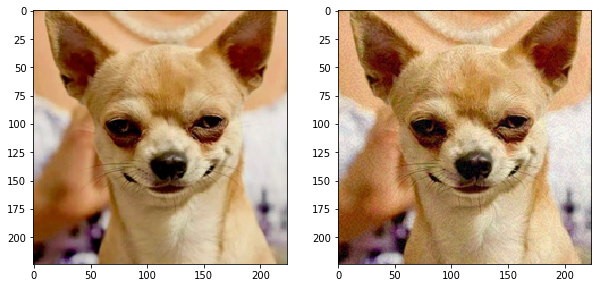

In [13]:
img_grad = img_tensor.grad
img_tensor = img_tensor.detach()

grad_sign = np.sign(img_grad.numpy()).astype(np.uint8)
epsilon = 0.05
new_img_array = np.asarray(unnorm(img_tensor.numpy()))+epsilon*grad_sign
new_img_array[new_img_array>255] = 255
new_img_array[new_img_array<0] = 0
new_img_array = new_img_array.astype(np.uint8)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(unnorm(img_tensor.numpy()).transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(new_img_array.transpose(1,2,0))

new_img_array = norm(new_img_array)
new_img_var = torch.FloatTensor(new_img_array)
new_img_var.requires_grad_(True)
new_out = model(new_img_var.unsqueeze(0))
new_out_np = new_out.data.numpy()
new_probs = softmax(new_out)
new_cls_idx = np.argmax(new_out_np)
print(str(new_cls_idx) + ":" + idx2class[new_cls_idx] + ":" + str(new_probs.data.numpy()[0][new_cls_idx]))